## Context

*Problem Statement:* Predict the probability that a candidate will be looking for a new job.
Essentially, we will be attempting to predict who is looking for a job and who is not.

*Note:* In industry, it is often difficult to deploy models that take hours to retrain daily.  A good model is often better - and more practical - than a perfect one.  Although this should be assessed on a case-by-case basis of course.

## Set Up Environment & Load the Data

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")        
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
import squarify
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 200

In [2]:
aug_train = pd.read_csv('aug_train.csv')
aug_test = pd.read_csv('aug_test.csv')
aug_train.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0


### Deal with missing values
As I have said in previous notebooks, dealing with missing values is often subjective.

I like to keep categorical data where I can, as perhaps the fact that we do not have a company size or the company type could actually tell us something useful about the datapoint.

Additionally, we will keep the null gender values as of these, 30% have a target in 1 in the dataset so this could in itself, be a telling data point, even if we don't quite understand it yet.

As a reminder: Target: 0 - Not looking for a job change, 1- Looking for a job change

In [3]:
print(aug_train.isna().mean())

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64


In [4]:
# We would like to keep categorical data where we can, as perhaps the fact that we do not have
# a company size or a company tupe could actually tell us something

aug_train['last_new_job'] = aug_train.last_new_job.apply(lambda x: 'Never' if x == 'never' else x)
aug_train['enrolled_university'][aug_train['enrolled_university'] == 'no_enrollment'] = 'No Enrollment' #just reads nicer
aug_train['company_size'] = aug_train['company_size'].apply(lambda x: '10-49' if x == '10/49' else x) #diff replacement method

aug_train['experience'] = aug_train['experience'].apply(lambda x: '0' if x == '<1' else x)
aug_train['experience'] = aug_train['experience'].apply(lambda x: '20' if x == '>20' else x)


aug_train['company_size'].fillna('0',inplace=True)
aug_train['company_type'].fillna('Unknown',inplace=True)
aug_train['major_discipline'].fillna('Unknown',inplace=True)
aug_train['gender'].fillna('Not provided',inplace=True)


# Repeat steps on Test set

aug_test['last_new_job'] = aug_test['last_new_job'].apply(lambda x: 'Never' if x == 'never' else x) #just reads nicer
aug_test['enrolled_university'][aug_test['enrolled_university'] == 'no_enrollment'] = 'No Enrollment' #just reads nicer
aug_test['company_size'] = aug_test['company_size'].apply(lambda x: '10-49' if x == '10/49' else x) #diff replacement method

aug_test['experience'] = aug_test['experience'].apply(lambda x: '0' if x == '<1' else x)
aug_test['experience'] = aug_test['experience'].apply(lambda x: '20' if x == '>20' else x)

aug_test['company_size'].fillna('0',inplace=True)
aug_test['company_type'].fillna('Unknown',inplace=True)
aug_test['major_discipline'].fillna('Unknown',inplace=True)
aug_test['gender'].fillna('Not provided',inplace=True)



# This is what I mean with respect to the gender categories:

aug_train['target'].groupby(aug_train['gender']).mean()

gender
Female          0.263328
Male            0.227819
Not provided    0.308119
Other           0.261780
Name: target, dtype: float64

In [5]:
# I will drop the remaining missing data

aug_train.dropna(inplace=True)
aug_test.dropna(inplace=True)
aug_train.isna().mean()

enrollee_id               0.0
city                      0.0
city_development_index    0.0
gender                    0.0
relevent_experience       0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
training_hours            0.0
target                    0.0
dtype: float64

In [6]:
# Converting objects to integers

aug_train['experience'] = aug_train['experience'].astype(str).astype(int)
aug_test['experience'] = aug_test['experience'].astype(str).astype(int)

aug_train['training_hours'] = aug_train['training_hours'].astype(str).astype(int)
aug_test['training_hours'] = aug_test['training_hours'].astype(str).astype(int)

In [7]:
aug_train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                  int64
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

It's helpful to order categorical variables. This gives us much more control over your visuals and enables you to tell the story you're trying to tell.

In [8]:
# Orders
ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
exp_yrs_order_2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']
company_order = ['Pvt Ltd','Unknown','Funded Startup','Public Sector','Early Stage Startup','NGO','Other']
 
# for visuals
train_df = aug_train
test_df = aug_test

## Data Visualization

This is intended as an exploratory visualization and not an explanatory one.

This will also make use of GridSpec - an object-oriented interface that allows us to easily partition our figure into several subplots and manipulate each subplot with 'axes' API.

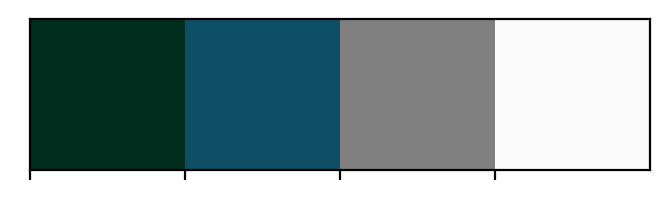

In [9]:
sns.palplot(['#002d1d','#0e4f66','gray','#fbfbfb'])

### How many job seekers are there?

First of all, we want to see how many job-seekers are in our training set.

Do we have a balanced dataset? Or is it imbalances? The answer to these questions may influence our models later on.

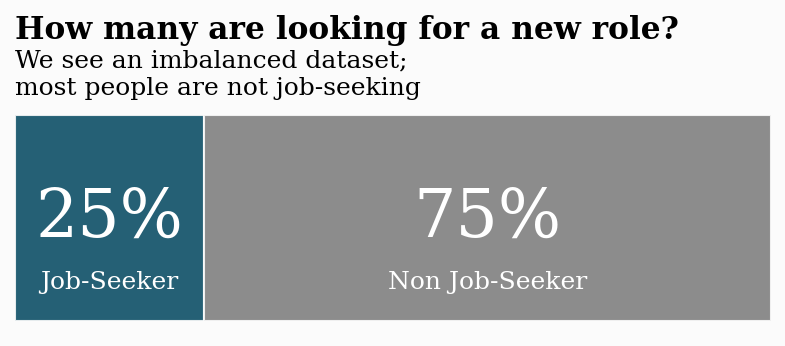

In [10]:
ratio = pd.DataFrame(train_df.target.value_counts(normalize=True).round(2)).T


fig, ax = plt.subplots(1,1,figsize=(6.5, 2),dpi=150)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color) 

ax.barh(ratio.index, ratio[1.0], color='#0e4f66', alpha=0.9, ec=background_color, label='Job-Seeker')
ax.barh(ratio.index, ratio[0.0], left=ratio[1.0], color='gray', alpha=0.9,ec=background_color, label='Non Job-Seeker')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.legend().set_visible(False)
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[1.0][i]*100)}%", xy=(ratio[1.0][i]/2, i),va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("Job-Seeker", xy=(ratio[1.0][i]/2, -0.25),va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',color='white')
    
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[0.0][i]*100)}%", xy=(ratio[1.0][i]+ratio[0.0][i]/2, i),va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("Non Job-Seeker", xy=(ratio[1.0][i]+ratio[0.0][i]/2, -0.25),va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',color='white')


fig.text(0.125,1.1,'How many are looking for a new role?', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.915,'We see an imbalanced dataset;\nmost people are not job-seeking',fontfamily='serif',fontsize=12)  


plt.show()

We have an imbalanced dataset - that is, there are many more non-job-seekers than job-seekers.

This is a problem that we can address later on.  For now, let's continue exploring the data.

### How do the trian and test sets compare to each other?

Here, I'll show an example of how you can use GridSpec.

GridSpec enables you to plot multiple plots and is highly customizable - a skill worth picking up!

This si really valuevale because you can conbey a lot of information in a small amount of space.

I'll compare the trian and test sets here:

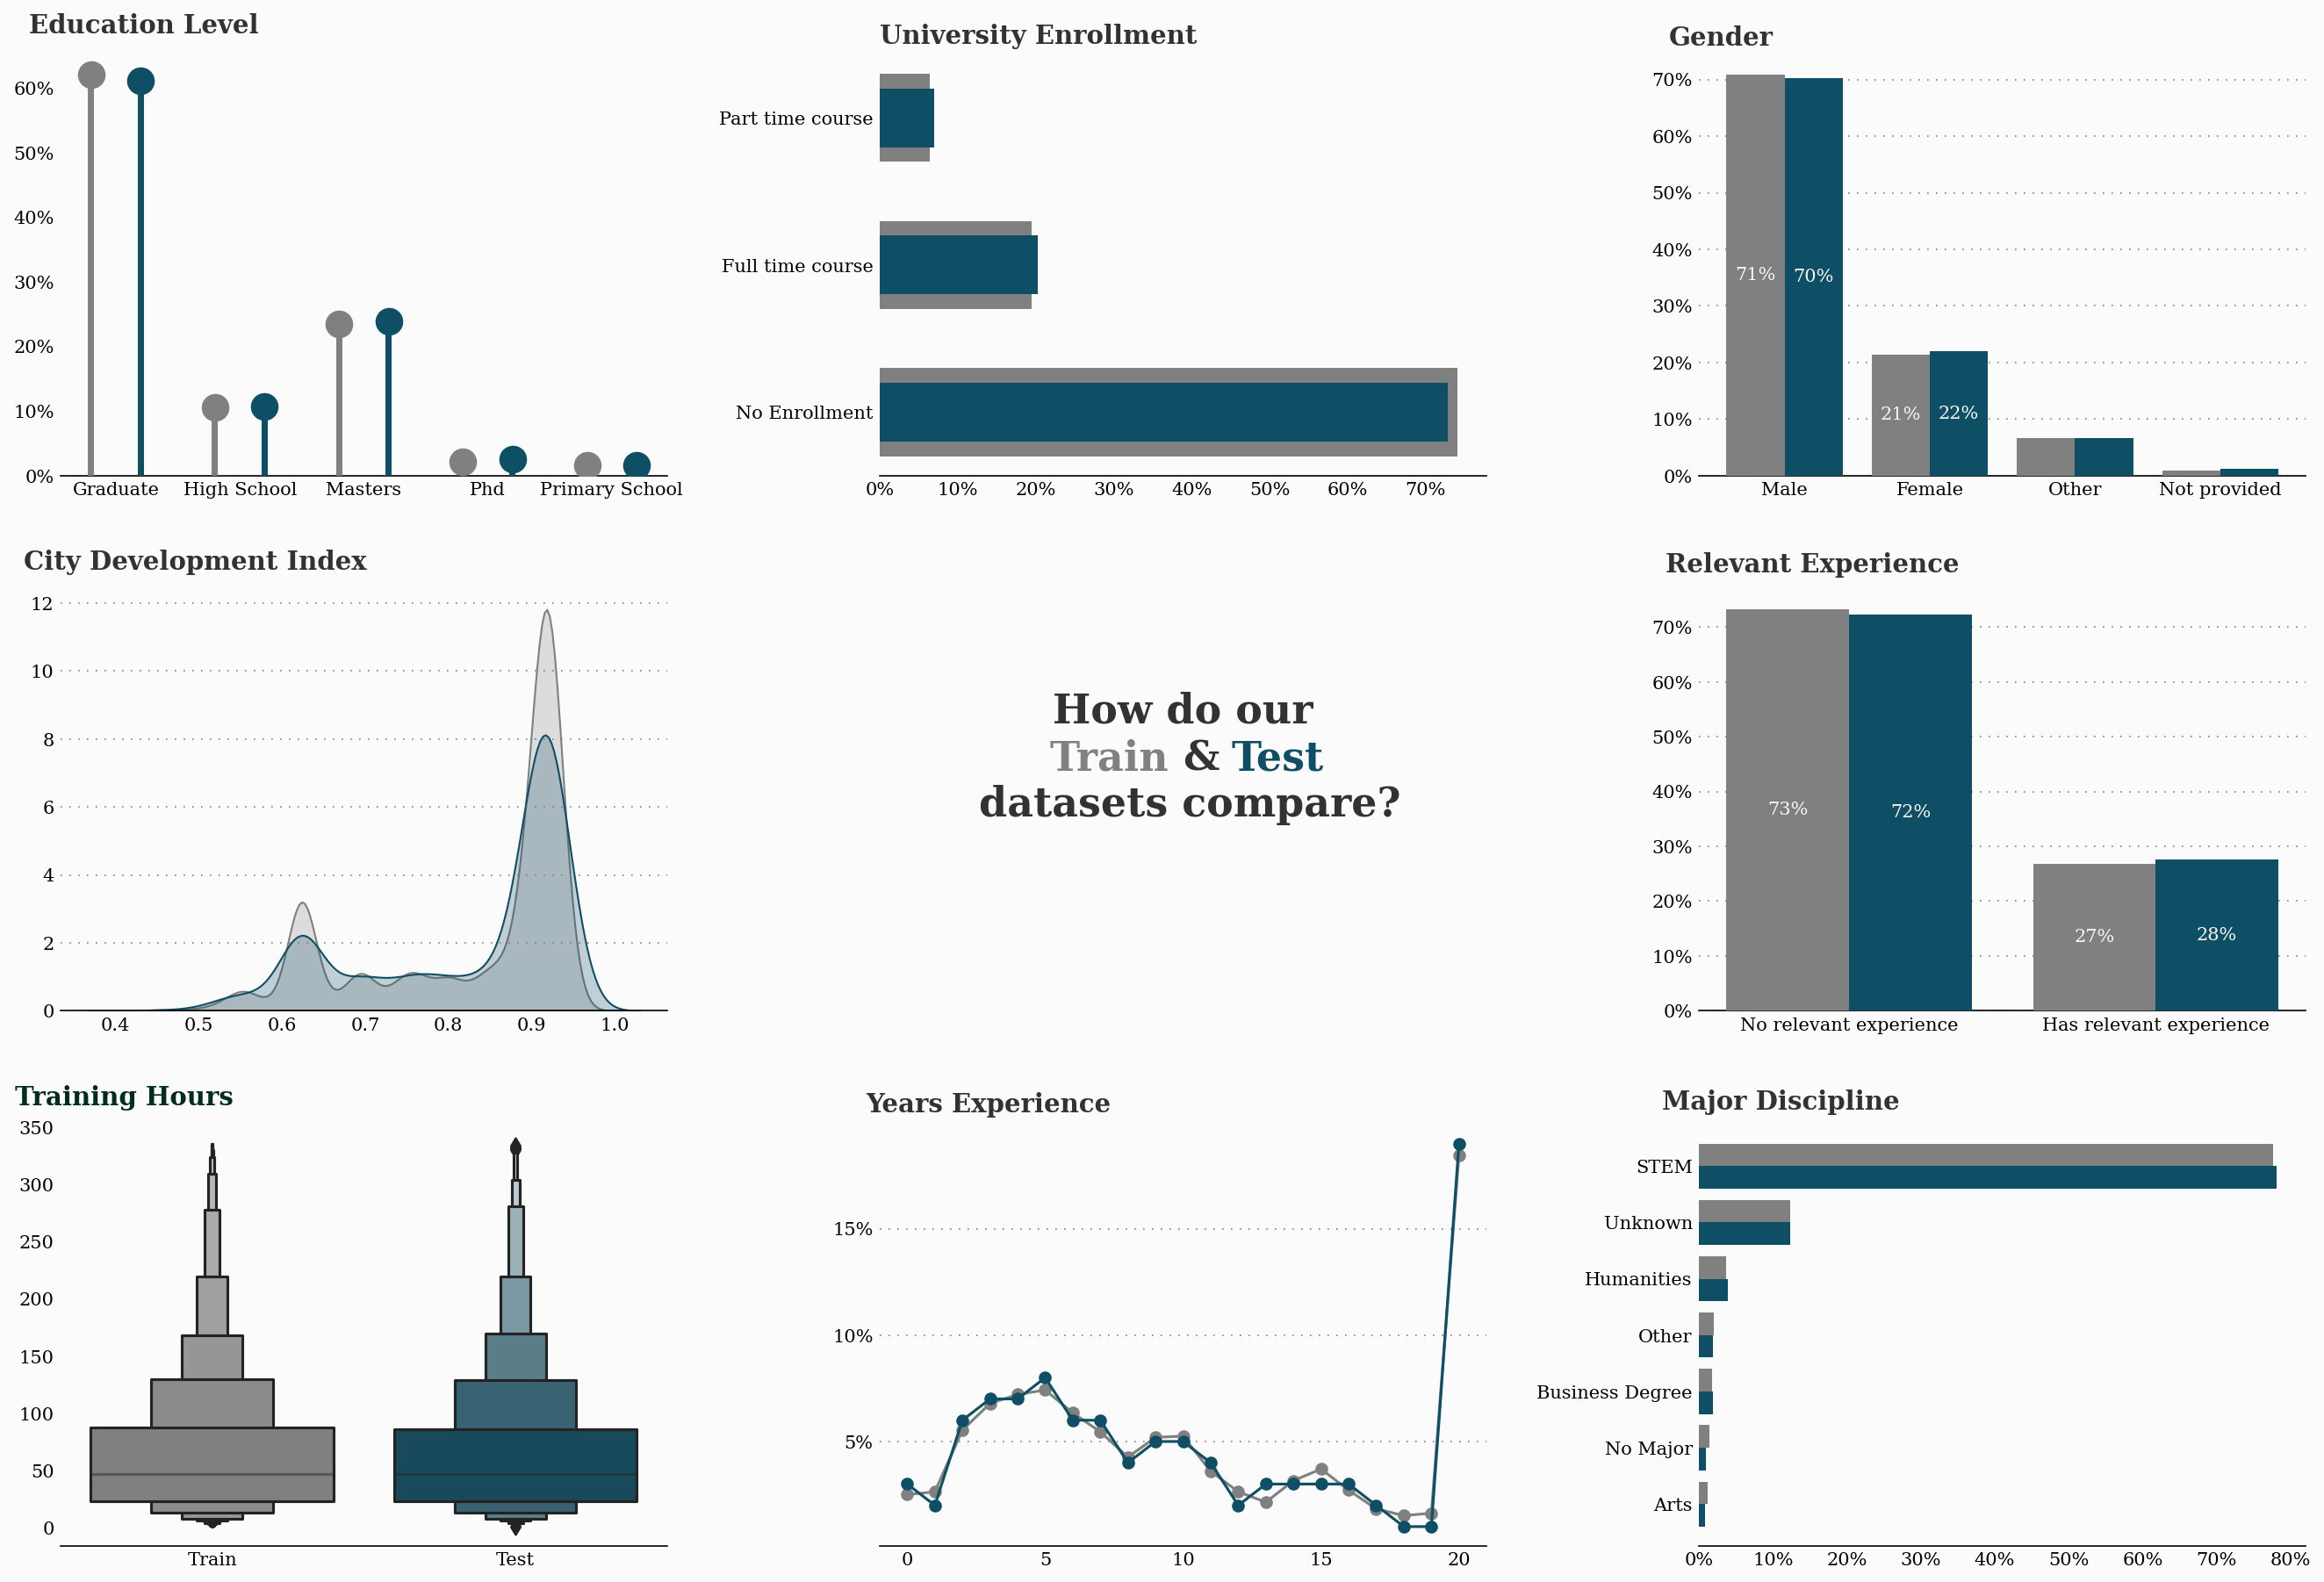

In [11]:
background_color = "#fbfbfb"

fig = plt.figure(figsize=(22,15),dpi=150)
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])


# Ax0 - EDUCATION LEVEL
train = pd.DataFrame(train_df["education_level"].value_counts())
train["Percentage"] = train["education_level"].apply(lambda x: x/sum(train["education_level"])*100)
train = train.sort_index()

test = pd.DataFrame(test_df["education_level"].value_counts())
test["Percentage"] = test["education_level"].apply(lambda x: x/sum(test["education_level"])*100)
test = test.sort_index()

ax0.bar(np.arange(len(train.index)), height=train["Percentage"], zorder=3, color="gray", width=0.05)
ax0.scatter(np.arange(len(train.index)), train["Percentage"], zorder=3,s=200, color="gray")
ax0.bar(np.arange(len(test.index))+0.4, height=test["Percentage"], zorder=3, color="#0e4f66", width=0.05)
ax0.scatter(np.arange(len(test.index))+0.4, test["Percentage"], zorder=3,s=200, color="#0e4f66")
ax0.text(-0.5, 68.5, 'Education Level', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax0.yaxis.set_major_formatter(mtick.PercentFormatter())
ax0.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax0.set_xticks(np.arange(len(train.index))+0.4 / 2)
ax0.set_xticklabels(list(train.index),rotation=0)


# Ax1 - ENROLLED IN UNIVESITY
train = pd.DataFrame(train_df["enrolled_university"].value_counts())
train["Percentage"] = train["enrolled_university"].apply(lambda x: x/sum(train["enrolled_university"])*100).loc[enroll_order]
test = pd.DataFrame(test_df["enrolled_university"].value_counts())
test["Percentage"] = test["enrolled_university"].apply(lambda x: x/sum(test["enrolled_university"])*100).loc[enroll_order]

ax1.text(0, 2.5, 'University Enrollment', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax1.barh(train.index, train['Percentage'], color="gray", zorder=3, height=0.6)
ax1.barh(test.index, test['Percentage'], color="#0e4f66", zorder=3, height=0.4)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))

###
# Ax2 - GENDER 
train = pd.DataFrame(train_df["gender"].value_counts())
train["Percentage"] = train["gender"].apply(lambda x: x/sum(train["gender"])*100)
test = pd.DataFrame(test_df["gender"].value_counts())
test["Percentage"] = test["gender"].apply(lambda x: x/sum(test["gender"])*100)

x = np.arange(len(train))
ax2.text(-0.6, 76, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=train["Percentage"], zorder=3, color="gray", width=0.4)
ax2.bar(x+0.4, height=test["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Male','Female','Other','Not provided'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], train["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], test["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    

    
## Ax 3 - CDI

ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
train = pd.DataFrame(train_df["city_development_index"])
test = pd.DataFrame(test_df["city_development_index"])
sns.kdeplot(train["city_development_index"], ax=ax3,color="gray", shade=True, label="Train")
sns.kdeplot(test["city_development_index"], ax=ax3, color="#0e4f66", shade=True, label="Test")
ax3.text(0.29, 13, 'City Development Index', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax3.set_ylabel('')    
ax3.set_xlabel('')

## AX4 - TITLE

ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.text(0.5, 0.6, 'How do our\n\n datasets compare?', horizontalalignment='center', verticalalignment='center',fontsize=22, fontweight='bold', fontfamily='serif', color="#323232")
ax4.text(0.28,0.57,"Train", fontweight="bold", fontfamily='serif', fontsize=22, color='gray')
ax4.text(0.5,0.57,"&", fontweight="bold", fontfamily='serif', fontsize=22, color='#323232')
ax4.text(0.58,0.57,"Test", fontweight="bold", fontfamily='serif', fontsize=22, color='#0e4f66')




### Ax5 - RELEVANT EXPERIENCE
train = pd.DataFrame(train_df["relevent_experience"].value_counts())
train["Percentage"] = train["relevent_experience"].apply(lambda x: x/sum(train["relevent_experience"])*100)
test = pd.DataFrame(test_df["relevent_experience"].value_counts())
test["Percentage"] = test["relevent_experience"].apply(lambda x: x/sum(test["relevent_experience"])*100)
x = np.arange(len(train))
ax5.text(-0.4, 80, 'Relevant Experience', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax5.bar(x, height=train["Percentage"], zorder=3, color="gray", width=0.4)
ax5.bar(x+0.4, height=test["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax5.set_xticks(x + 0.4 / 2)
ax5.set_xticklabels(['No relevant experience','Has relevant experience'])
ax5.yaxis.set_major_formatter(mtick.PercentFormatter())
ax5.yaxis.set_major_locator(mtick.MultipleLocator(10))

for i,j in zip([0, 1, 2], train["Percentage"]):
    ax5.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1, 2], test["Percentage"]):
    ax5.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

    
    
# Ax6 - TRAINING HOURS
train = pd.DataFrame(train_df["training_hours"])
train["TrainTest"] = "Train"
test = pd.DataFrame(test_df["training_hours"])
test["TrainTest"] = "Test"
ax6.text(-0.65, 370, 'Training Hours', fontsize=14, fontweight='bold', fontfamily='serif', color="#002d1d")
comb_graph_temp_df = pd.concat([train, test], axis=0)
sns.boxenplot(ax=ax6, y="training_hours", x="TrainTest", data=comb_graph_temp_df, palette=["gray", "#0e4f66"])
ax6.set_xlabel("")
ax6.set_ylabel("")


# Ax7 - EXPERIENCE YRS
train = pd.DataFrame(train_df["experience"].value_counts())
train["Percentage"] = train["experience"].apply(lambda x: x/sum(train["experience"])*100)
train = train.sort_index()
test = pd.DataFrame(test_df["experience"].value_counts())
test["Percentage"] = round(test["experience"].apply(lambda x: x/sum(test["experience"])*100),).astype(int)
test = test.sort_index()
ax7.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax7.plot(train.index, train["Percentage"], zorder=3, color="gray", marker='o')
ax7.plot(test.index, test["Percentage"], zorder=3, color="#0e4f66", marker='o')
ax7.text(-1.5, 20.5, 'Years Experience', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax7.set_yticklabels(labels = ['0   ', '5%','10%','15%'])
ax7.xaxis.set_major_locator(mtick.MultipleLocator(5))
ax7.yaxis.set_major_locator(mtick.MultipleLocator(5))


# Ax8 - MAJOR DISCIPLINE
train = pd.DataFrame(train_df["major_discipline"].value_counts())
train["Percentage"] = train["major_discipline"].apply(lambda x: x/sum(train["major_discipline"])*100)
test = pd.DataFrame(test_df["major_discipline"].value_counts())
test["Percentage"] = test["major_discipline"].apply(lambda x: x/sum(test["major_discipline"])*100)

ax8.barh(np.arange(len(train.index)), train["Percentage"], zorder=3, color="gray", height=0.4)
ax8.barh(np.arange(len(test.index))+0.4, test["Percentage"], zorder=3, color="#0e4f66", height=0.4)
ax8.text(-5, -0.8, 'Major Discipline', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.xaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(1))
ax8.set_yticks(np.arange(len(test.index))+0.4 / 2)
ax8.set_yticklabels(list(test.index))
ax8.invert_yaxis()



for i in range(0,9):
    locals()["ax"+str(i)].set_facecolor(background_color) 
    
for i in range(0,9):
    locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)


for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)

plt.show()

#### The train and test sets are similar! That's good news

If the training set was wildly different characteristics to our test set then we might have some difficulties training models. 

We'd need to ask if the training population can really help us predict the target.

In this case though, we're fine.

### Now let's focus on the Training set and explore the data...

You'll note that I often incoroprate text in to my visuals. I'll often an annotations to the plots themselves, for example at the 'mean', or at peaks in the data etc.

In this case, I've included an explanation of what we're seeing and what it might mean. This helps your audience to understand your data, but it also helps them to get thinking in a way that is in line with the story you are trying to craft.

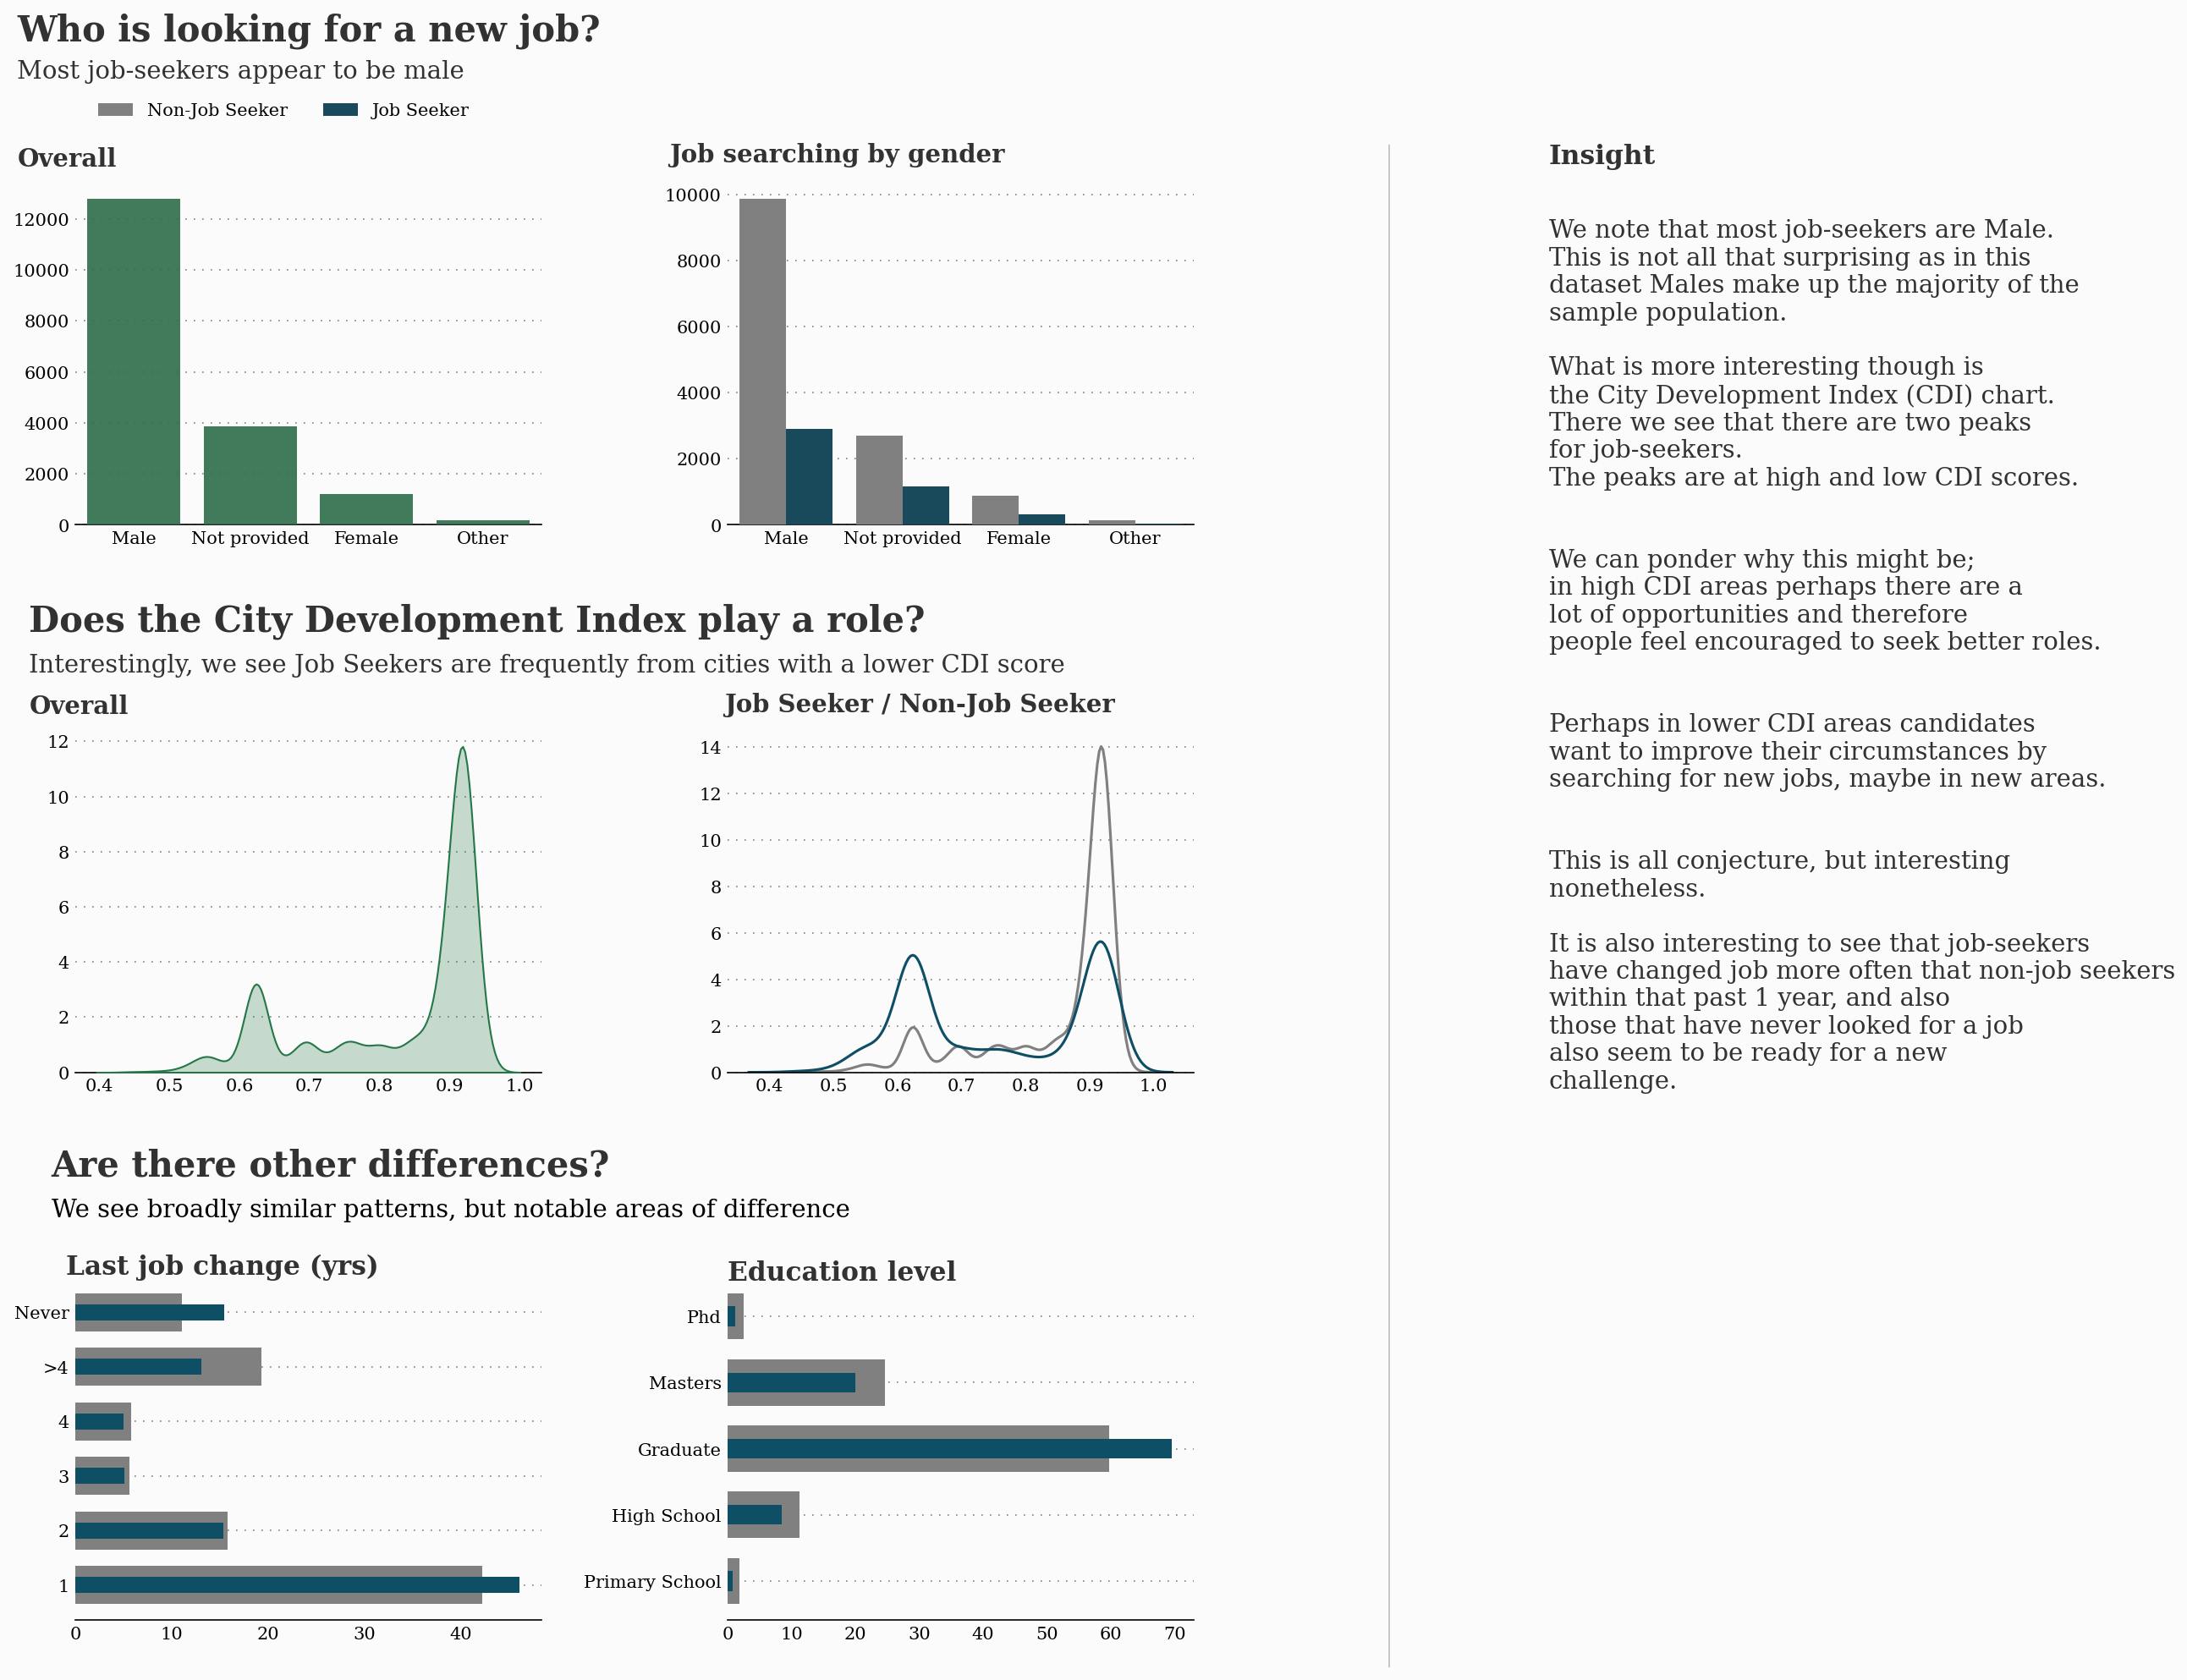

In [12]:
color_palette=["gray","#0e4f66"]
fig = plt.figure(figsize=(18,15), dpi=150)
fig.patch.set_facecolor(background_color) # figure background color
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.4, hspace=0.6)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])

# Distribution
ax0.text(-1, 19000, 'Who is looking for a new job?', fontsize=20, fontweight='bold', fontfamily='serif', color="#323232")
ax0.text(-1, 17500, 'Most job-seekers appear to be male', fontsize=14, fontweight='light', fontfamily='serif', color="#323232")
ax0.text(-1, 14050, 'Overall', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
sns.countplot(x=train_df["gender"], color="#247747", ax=ax0, zorder=3,alpha=0.9)

# Gender
ax1.text(-1, 11000, 'Job searching by gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
sns.countplot(x="gender", hue="target", data=train_df, palette=color_palette, ax=ax1, zorder=3)
legend_labels, _= ax1.get_legend_handles_labels()
ax1.legend(legend_labels, ["Non-Job Seeker", "Job Seeker"], ncol=2, bbox_to_anchor=(-0.52, 1.28), facecolor=background_color, edgecolor=background_color)

# CDI
ax2.text(0.3, 16, 'Does the City Development Index play a role?', fontsize=20, fontweight='bold', fontfamily='serif', color="#323232")
ax2.text(0.3, 14.5, 'Interestingly, we see Job Seekers are frequently from cities with a lower CDI score', fontsize=14, fontweight='light', fontfamily='serif', color="#323232")
ax2.text(0.3, 13, 'Overall', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
sns.kdeplot(train_df["city_development_index"], color="#247747", shade=True, ax=ax2, zorder=3)

ax3.text(0.33, 15.5, 'Job Seeker / Non-Job Seeker', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
sns.kdeplot(train_df.loc[(train_df["target"]==0), "city_development_index"], color="gray", label="Not Survived", ax=ax3)
sns.kdeplot(train_df.loc[(train_df["target"]==1), "city_development_index"], color="#0e4f66", label="Survived", ax=ax3)


###
aug_train['count'] = 1
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]

job_change = aug_train.groupby(['education_level','last_new_job'])['experience'].sum().unstack().loc[ed_order,job_order]

job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack()
notseek_job_change = no_job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T
seek_job_change = job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T

notseek_job_change.columns = ['count']
seek_job_change.columns = ['count']

notseek_job_change["percentage"] = notseek_job_change["count"].apply(lambda x: x/sum(notseek_job_change["count"])) *100
seek_job_change["percentage"] = seek_job_change["count"].apply(lambda x: x/sum(seek_job_change["count"])) *100

ed_notseek_job_change = no_job_hunt_only.groupby(['target','education_level'])['count'].sum().unstack().T.loc[ed_order]
ed_seek_job_change = job_hunt_only.groupby(['target','education_level'])['count'].sum().unstack().T.loc[ed_order]

ed_notseek_job_change.columns = ['count']
ed_seek_job_change.columns = ['count']

ed_notseek_job_change["percentage"] = ed_notseek_job_change["count"].apply(lambda x: x/sum(ed_notseek_job_change["count"])) *100
ed_seek_job_change["percentage"] = ed_seek_job_change["count"].apply(lambda x: x/sum(ed_seek_job_change["count"])) *100

###

ax4.barh(notseek_job_change.index, notseek_job_change['percentage'], color="gray", zorder=3, height=0.7)
ax4.barh(seek_job_change.index, seek_job_change['percentage'], color="#0e4f66", zorder=3, height=0.3)
ax4.xaxis.set_major_locator(mtick.MultipleLocator(10))


##
ax5.barh(ed_notseek_job_change.index, ed_notseek_job_change['percentage'], color="gray", zorder=3, height=0.7)
ax5.barh(ed_seek_job_change.index, ed_seek_job_change['percentage'], color="#0e4f66", zorder=3, height=0.3)
ax5.xaxis.set_major_locator(mtick.MultipleLocator(10))

##
ax4.text(-1, 5.7, 'Last job change (yrs)',fontsize=15, fontweight='bold', fontfamily='serif',color='#323232')
ax5.text(0, 4.55, 'Education level', fontsize=15, fontweight='bold', fontfamily='serif',color='#323232')

ax4.text(-2.5, 7.5, 'Are there other differences?', 
         fontsize=20, fontweight='bold', fontfamily='serif',color='#323232')

ax4.text(-2.5, 6.75, 
         'We see broadly similar patterns, but notable areas of difference', 
         fontsize=14, fontweight='light', fontfamily='serif')


####

fig.text(0.77, 0.89
         , 'Insight', fontsize=15, fontweight='bold', fontfamily='serif',color='#323232')
fig.text(0.77, 0.39, '''
We note that most job-seekers are Male.
This is not all that surprising as in this
dataset Males make up the majority of the
sample population.

What is more interesting though is
the City Development Index (CDI) chart.
There we see that there are two peaks
for job-seekers. 
The peaks are at high and low CDI scores. 


We can ponder why this might be;
in high CDI areas perhaps there are a 
lot of opportunities and therefore
people feel encouraged to seek better roles.


Perhaps in lower CDI areas candidates
want to improve their circumstances by
searching for new jobs, maybe in new areas. 


This is all conjecture, but interesting
nonetheless.

It is also interesting to see that job-seekers
have changed job more often that non-job seekers
within that past 1 year, and also
those that have never looked for a job
also seem to be ready for a new
challenge.
'''
         , fontsize=14, fontweight='light', fontfamily='serif',color='#323232')

import matplotlib.lines as lines
l1 = lines.Line2D([0.7, 0.7], [0.1, 0.9], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

for s in ["top","right","left"]:
    for i in range(0,6):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        
for i in range(0,6):
        locals()["ax"+str(i)].set_facecolor(background_color)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)
        locals()["ax"+str(i)].grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))      

        
for x in range(0,4):
    for y in range(0,4):
        locals()["ax"+str(x)].set_xlabel("")
        locals()["ax"+str(y)].set_ylabel("")

plt.show()

#### Let's now explore other factors like company size & employee experience...
Do more experienced candidates seek new challenges?

Do employees at larger companies feel less valued?

Do employees at smaller companies crave new opportunities?

Both seem plausible.  These are the questions that good EDA can answer!

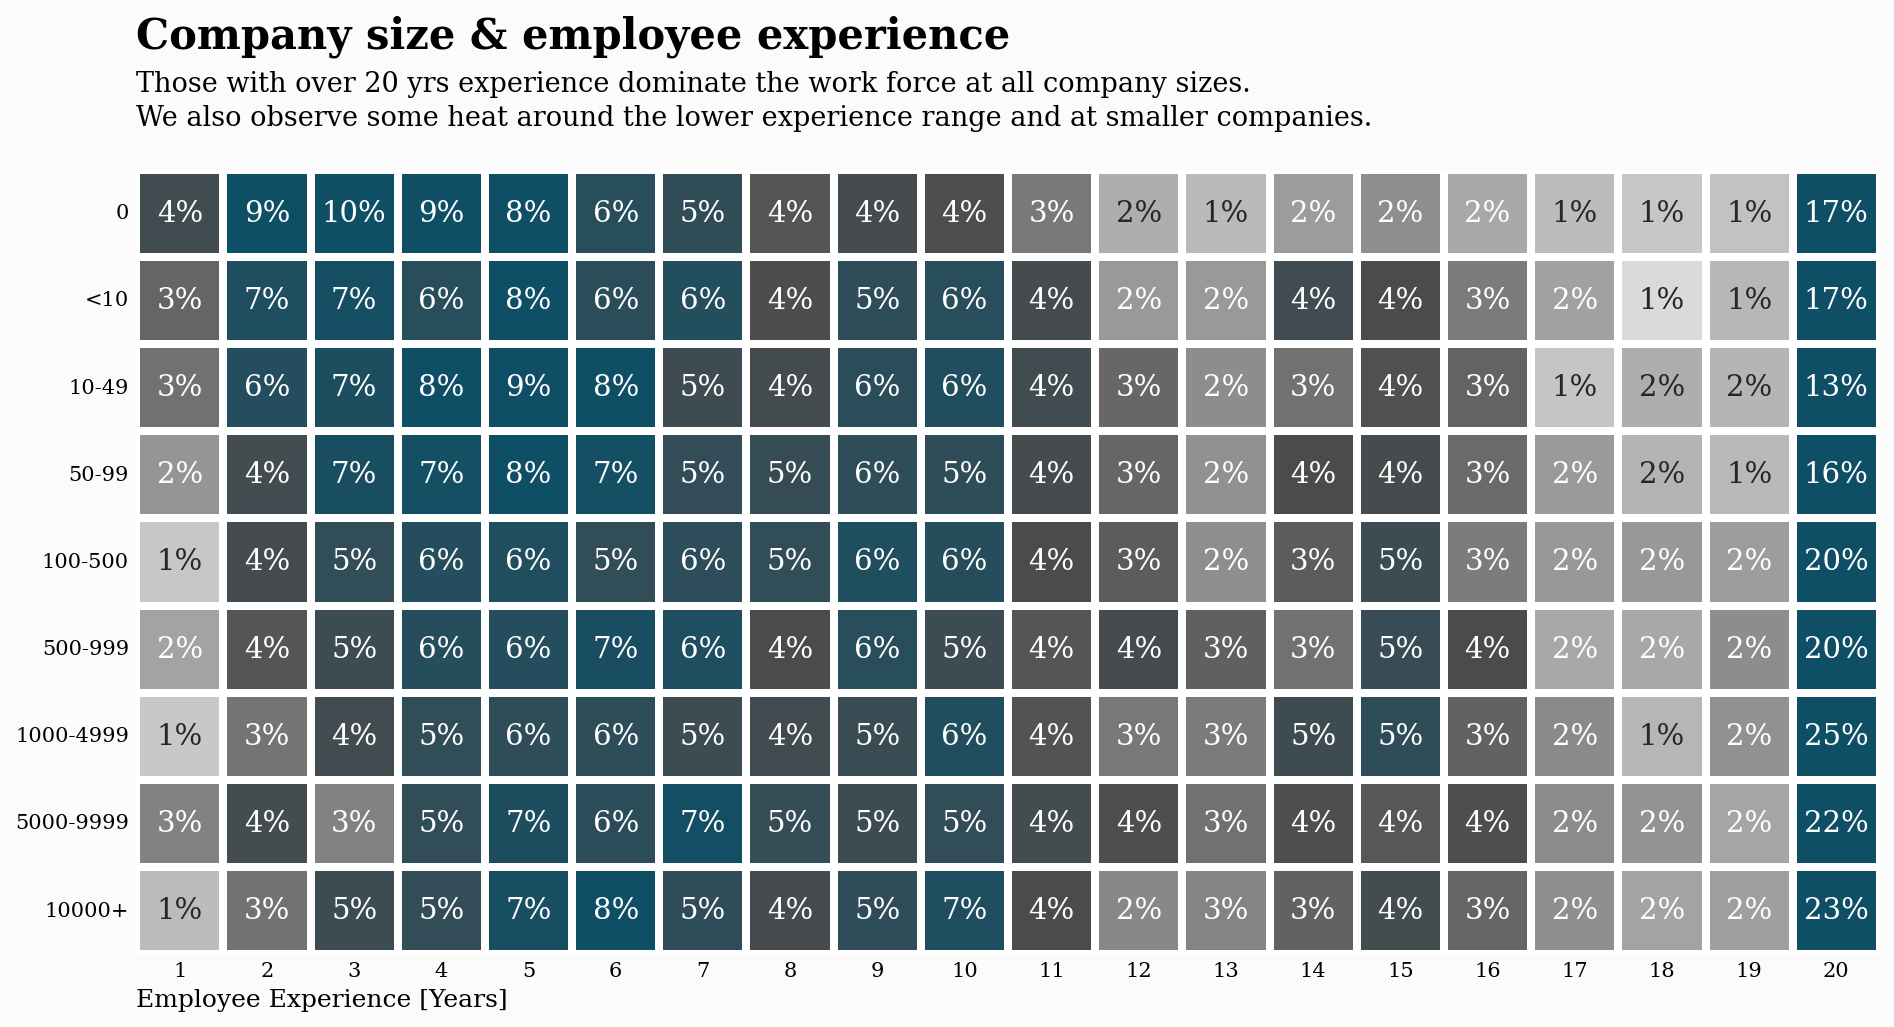

In [13]:
pv_gen_size = pd.pivot_table(aug_train, values='count',index=['gender'],columns=['company_size'],aggfunc=np.sum).loc[gender_order, size_order]
ct_gen_size = pd.crosstab(aug_train['company_size'],aug_train['experience'], normalize='index').loc[size_order,exp_yrs_order_2]


fig = plt.figure(figsize=(15,10), dpi=150) 
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0, hspace=-0.09)
ax0 = fig.add_subplot(gs[:,:])

colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(ax=ax0, data=ct_gen_size, linewidths=.1, vmin=0, vmax=0.075,
            square=True, cbar=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})

 
ax0.set_facecolor(background_color) 
ax0.set_xlabel("Employee Experience [Years]",fontfamily='serif',fontsize=12,loc='left')
ax0.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

ax0.text(0, -1.4, 
         'Company size & employee experience', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.9, 
         'Those with over 20 yrs experience dominate the work force at all company sizes.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )
ax0.text(0, -0.5, 
         'We also observe some heat around the lower experience range and at smaller companies.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )

ax0.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

It appears that as employee experience increases, they tend to work at larger companies.

Why might this be? Perhaps larger companies pay better, or perhaps they have more job security.

### Employee Experience & Company Size
Is there a noticeable difference between job-seekers and non-job-seekers?

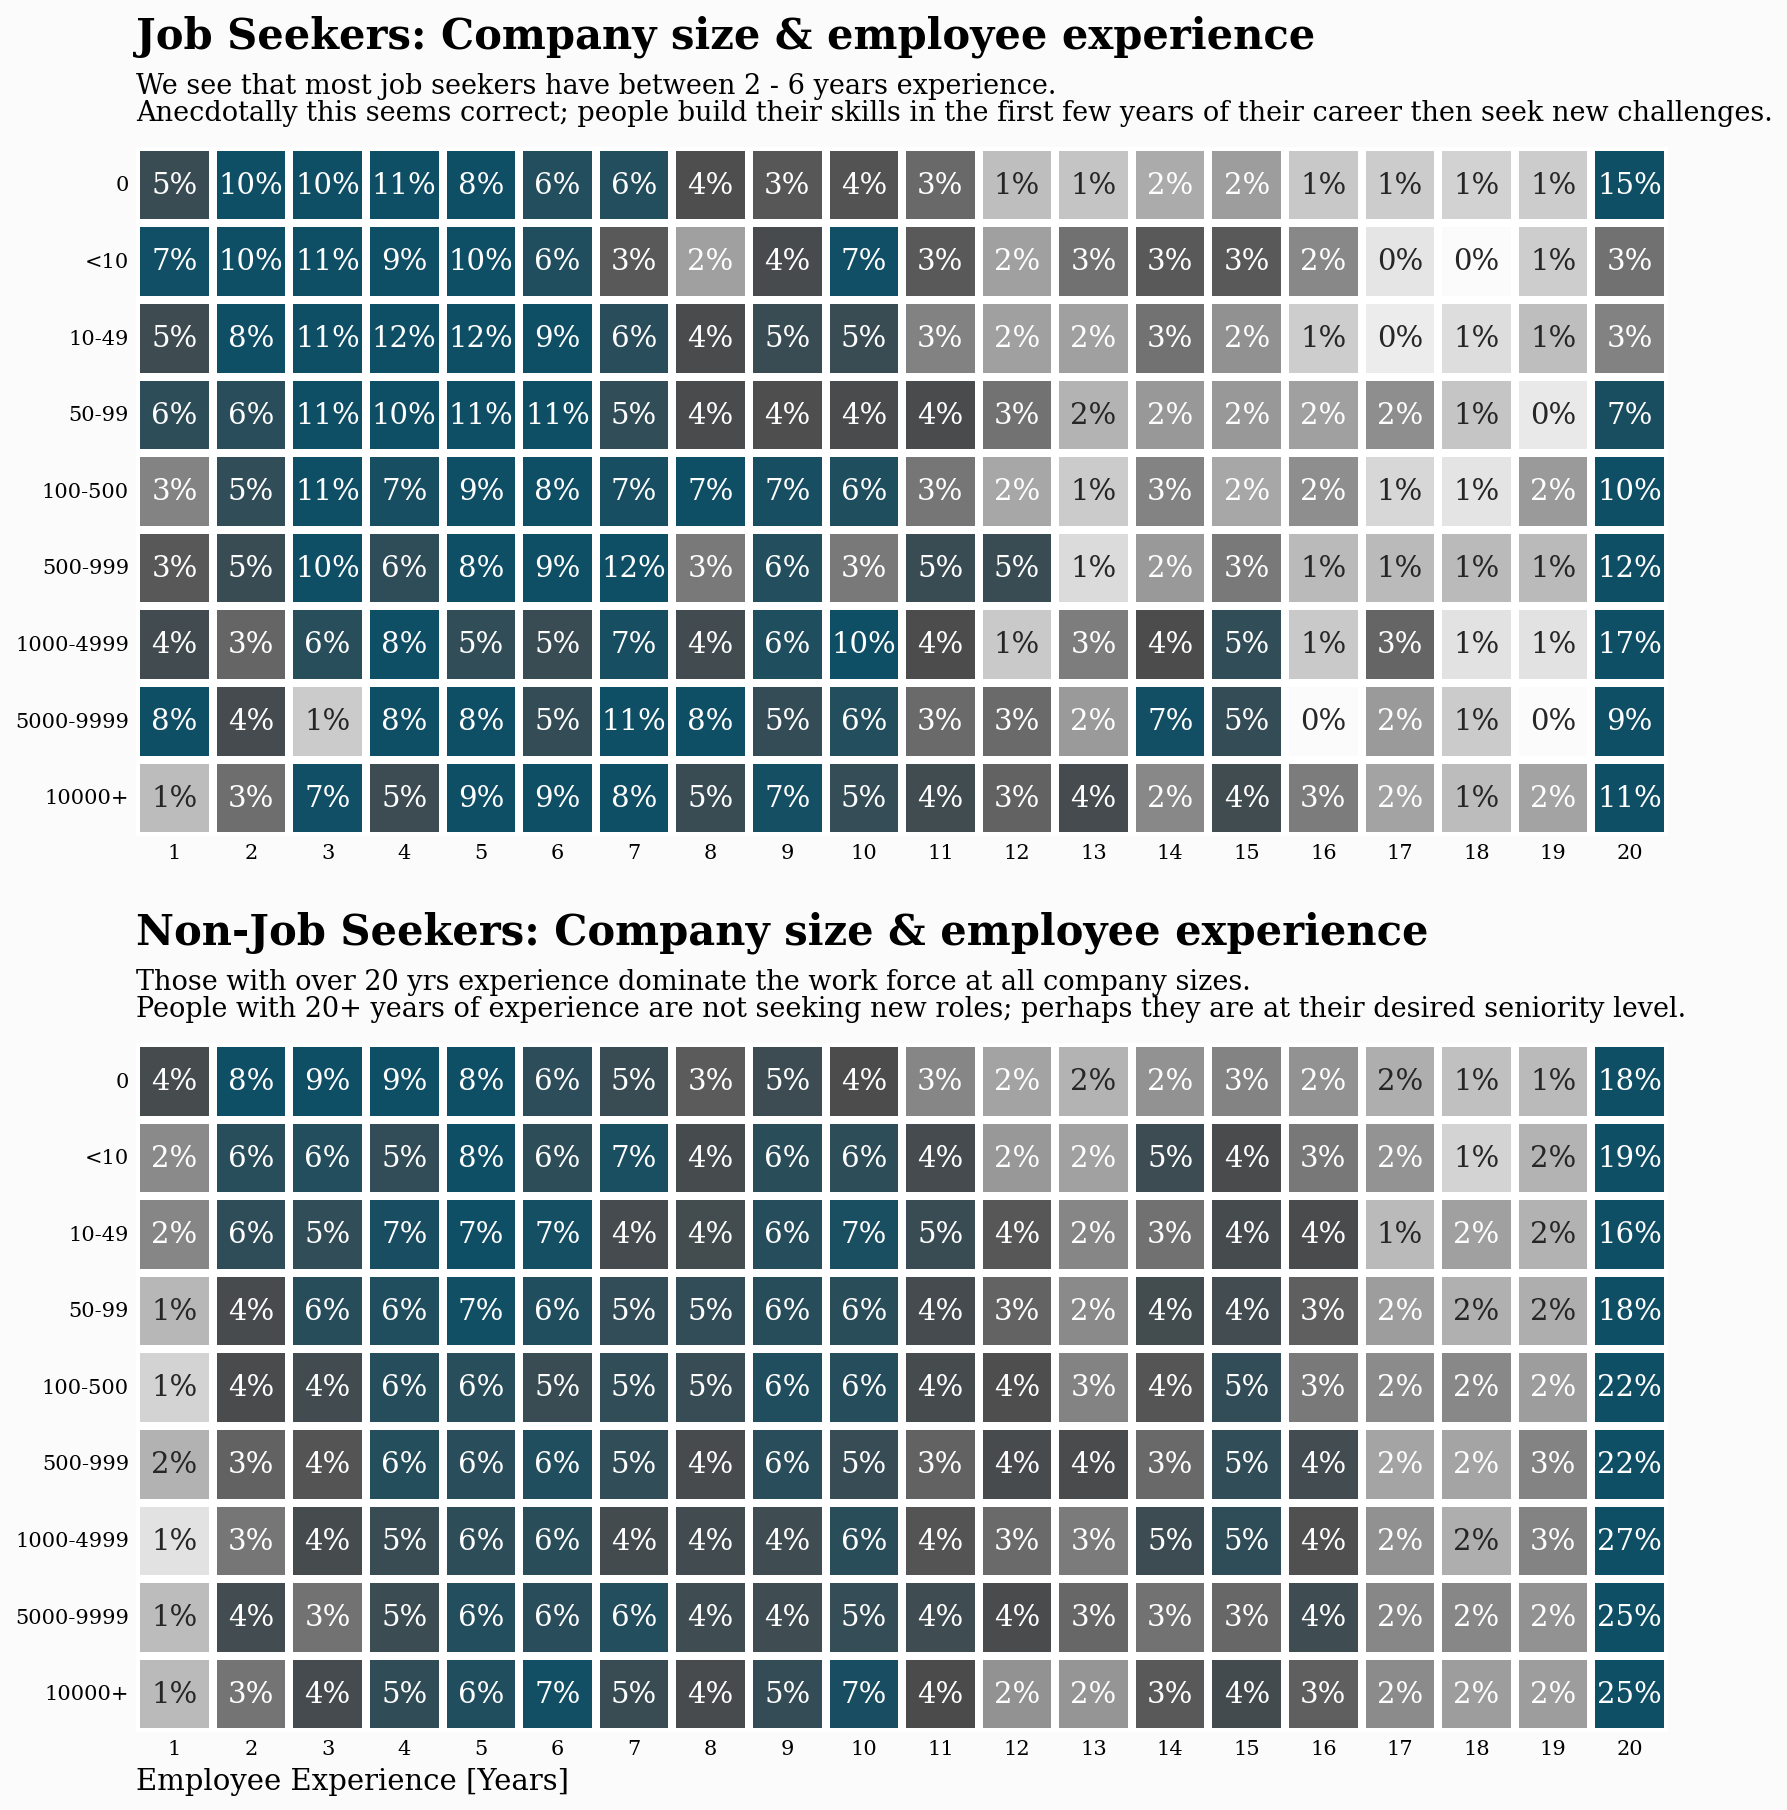

In [14]:
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]

job_seek = pd.crosstab(job_hunt_only['company_size'],job_hunt_only['experience'], normalize='index').loc[size_order,exp_yrs_order_2]
no_seek = pd.crosstab(no_job_hunt_only['company_size'],no_job_hunt_only['experience'], normalize='index').loc[size_order,exp_yrs_order_2]

###
fig = plt.figure(figsize=(14,14),dpi=150)
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.2, hspace=0.3)
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])

colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(ax=ax0, data=job_seek, linewidths=.1, vmin=0, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})

sns.heatmap(ax=ax1, data=no_seek, linewidths=.1, vmin=0, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})

ax0.set_facecolor(background_color) 
ax0.set_xlabel("")
ax0.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)
    
ax0.set_xlabel("")
ax0.set_ylabel("")
ax1.set_xlabel("Employee Experience [Years]",fontfamily='serif',fontsize=14,loc='left')
ax1.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)

    
ax0.text(0, -1.3, 
         'Job Seekers: Company size & employee experience', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax1.text(0, -0.7, 
         'Those with over 20 yrs experience dominate the work force at all company sizes.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )
ax1.text(0, -0.35, 
         'People with 20+ years of experience are not seeking new roles; perhaps they are at their desired seniority level.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )

ax1.text(0, -1.3, 
         'Non-Job Seekers: Company size & employee experience', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.7, 
         'We see that most job seekers have between 2 - 6 years experience.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )
ax0.text(0, -0.35, 
         'Anecdotally this seems correct; people build their skills in the first few years of their career then seek new challenges.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

### Education
We've explored some interesting features of our data, including employee experiences and company size.

Let's throw education in the mix.

Do job-seekers have a higher education level? Are they less educated? Or is there no difference at all?

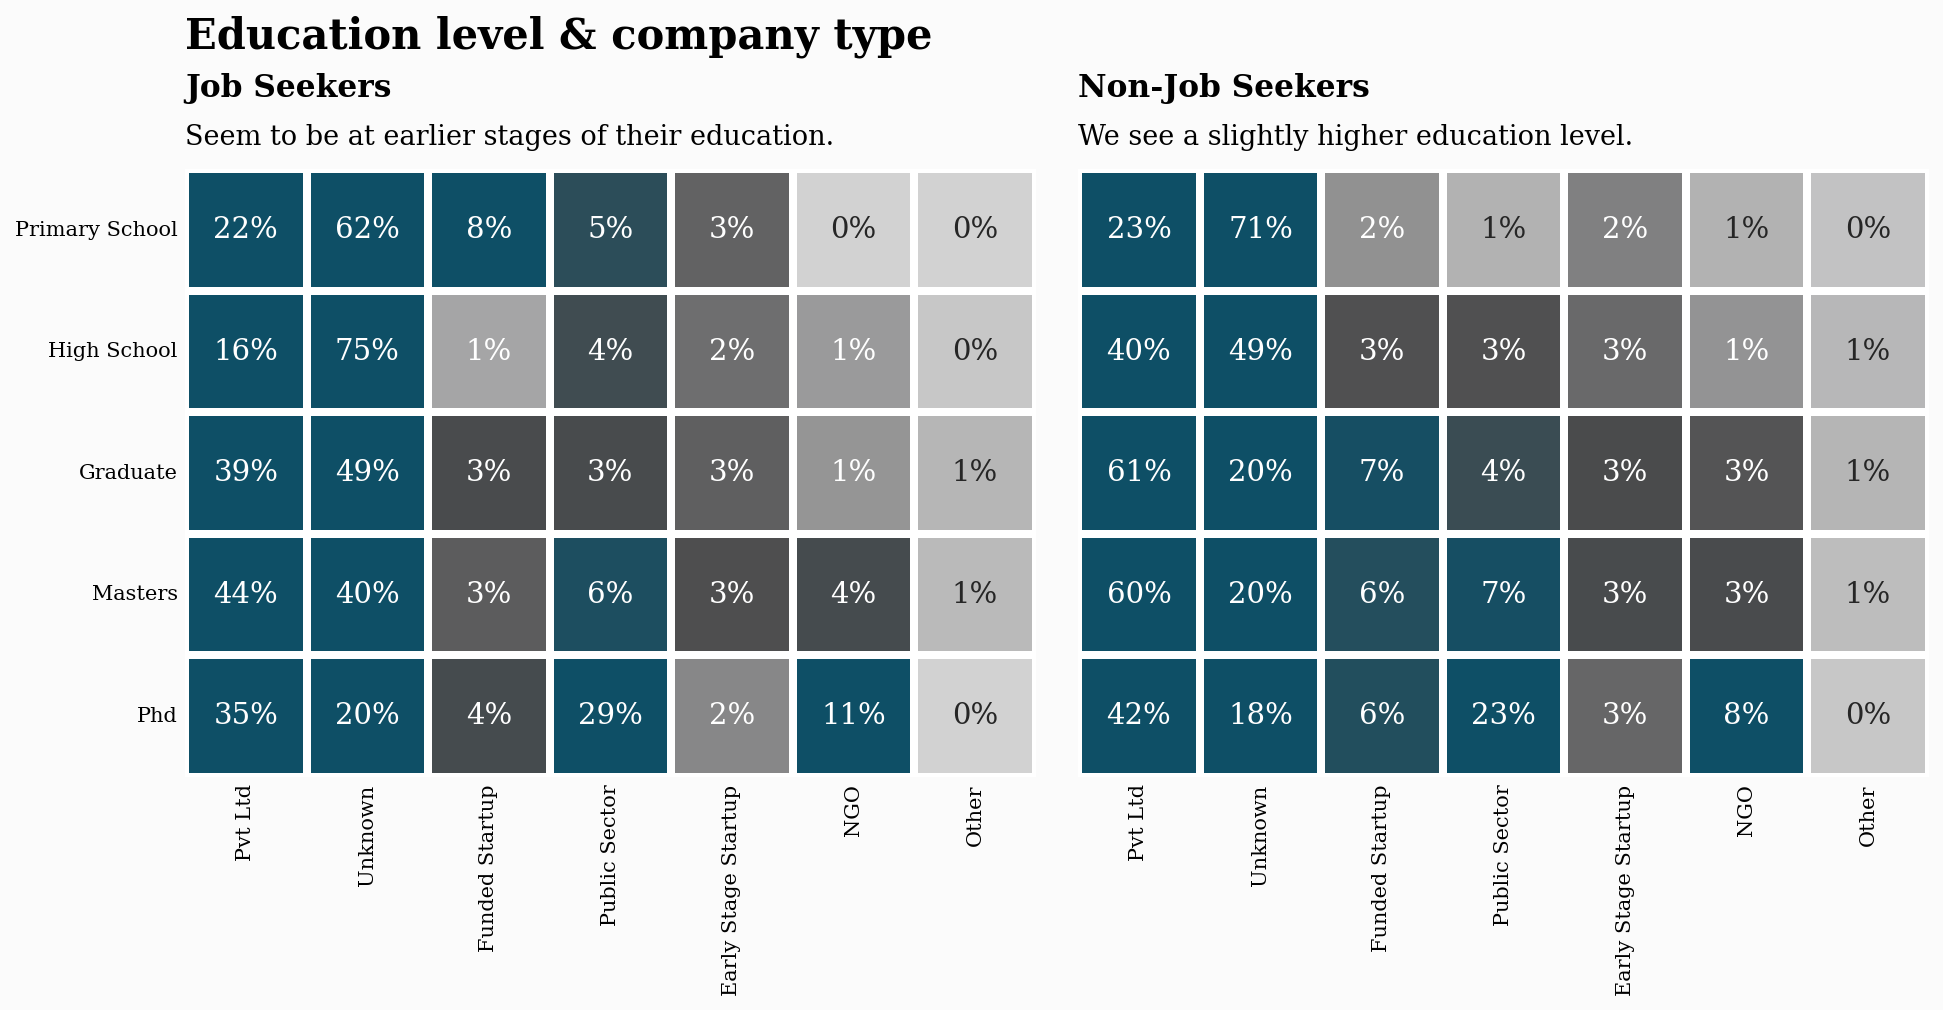

In [15]:
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]

job_seek = pd.crosstab(job_hunt_only['education_level'],job_hunt_only['company_type'], normalize='index').loc[ed_order,company_order]
no_seek = pd.crosstab(no_job_hunt_only['education_level'],no_job_hunt_only['company_type'], normalize='index').loc[ed_order,company_order]


fig = plt.figure(figsize=(15,15),dpi=150)
fig.patch.set_facecolor(background_color)

gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.05, hspace=0.3)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])


colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(ax=ax0, data=job_seek, linewidths=.1, vmin=-0.01, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})

sns.heatmap(ax=ax1, data=no_seek, linewidths=.1, vmin=-0.01, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,yticklabels=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})


ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color) 
ax0.set_xlabel("")
ax0.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)


ax1.set_xlabel("")
ax1.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)
    
    
ax0.text(0, -1, 
         'Education level & company type', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.6, 
         'Job Seekers', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.2, 
         'Seem to be at earlier stages of their education.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )


###

ax1.text(0, -0.6, 
         'Non-Job Seekers', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
        )
ax1.text(0, -0.2, 
         'We see a slightly higher education level.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )
    

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

These results are interesting. It does appear that job-seekrs are less educated - I would suggest that this is because they are younger and still on their educaiton journey, and are also seeking new challenges.

What do you think?

In [16]:
# Orders

ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']
company_order = ['Pvt Ltd','Unknown','Funded Startup','Public Sector','Early Stage Startup','NGO','Other']

In [17]:
data = train_df
data['count'] = 1

data_plot = pd.pivot_table(data, values='count', index=['major_discipline'], columns=['company_size'], aggfunc=np.sum).fillna(0).astype(int).stack().loc[disc_order, size_order]
data_job_seek = pd.pivot_table(data[data['target']==1], values='count', index=['major_discipline'], columns=['company_size'], aggfunc=np.sum).fillna(0).astype(int).stack().loc[disc_order, size_order]
data_no_job_seek = pd.pivot_table(data[data['target']==0], values='count', index=['major_discipline'], columns=['company_size'], aggfunc=np.sum).fillna(0).astype(int).stack().loc[disc_order, size_order]

In [18]:
# https://stackoverflow.com/questions/56337732/how-to-plot-scatter-pie-chart-using-matplotlib
def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 30)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 30)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker, alpha=0.9, ec=background_color)

### Going Deeper
A plot like this is not precise - but it does give a quick overview of a lot of information.  It engages the reader and encourages them to spend time looking at the plot - it gets them thinking.

We see that the vast majority of employees are STEM graduates. These graduates are also quite well represented at all company sizes

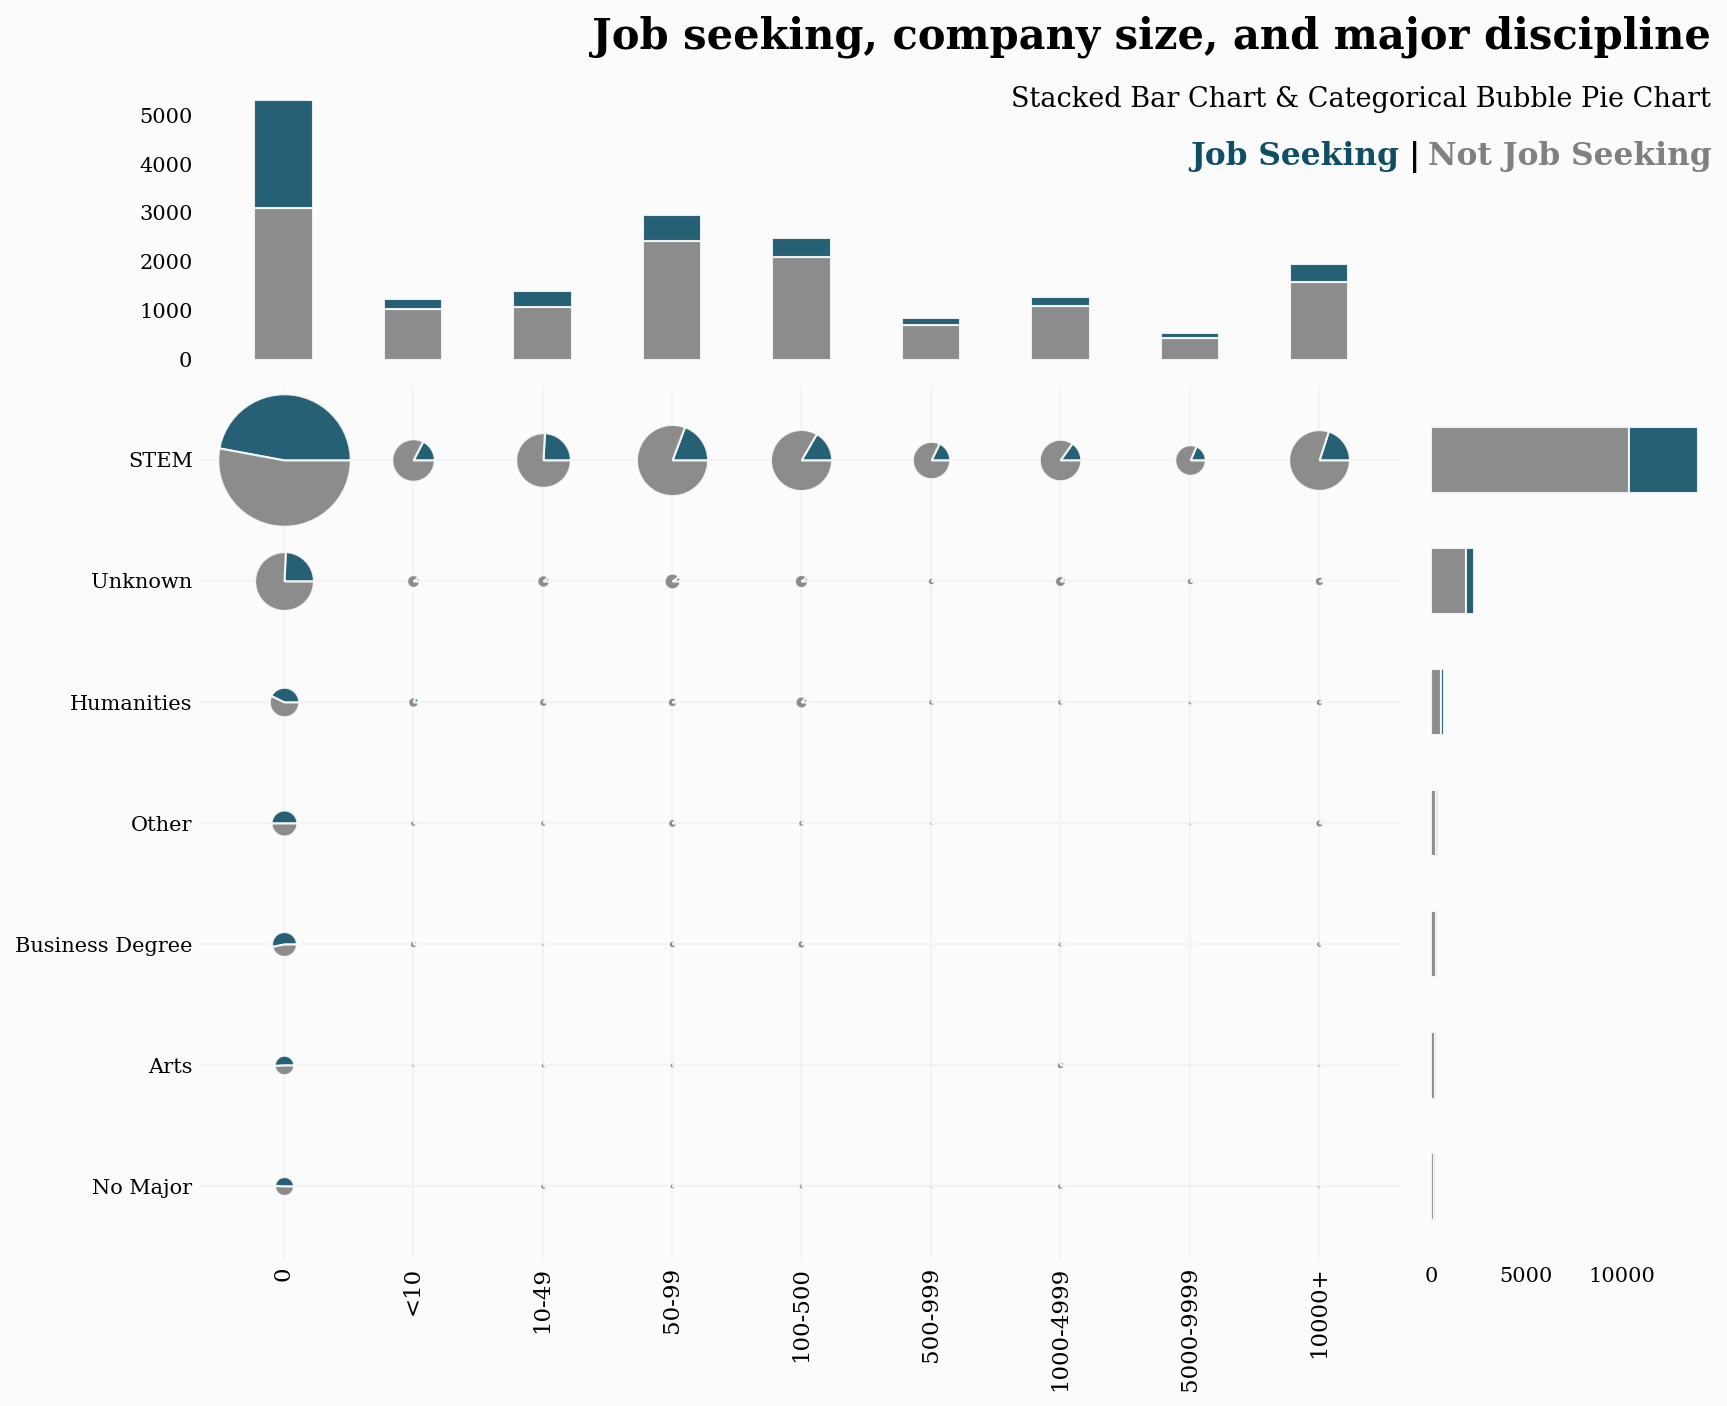

In [19]:
# Plot inspired by Subin An

fig = plt.figure(figsize=(13, 13), dpi=150)
gs = fig.add_gridspec(5, 5)
gs.update(wspace=0.1, hspace=0.1)
fig.patch.set_facecolor(background_color) 

# Pie 

ax_centre = fig.add_subplot(gs[1:4, 0:4]) 
for cl_idx in disc_order[::-1]:
    for age_idx in size_order:
        seek = data_job_seek[cl_idx][age_idx]
        no_seek = data_no_job_seek[cl_idx][age_idx]
        total = data_job_seek[cl_idx][age_idx]
        drawPieMarker([age_idx],[cl_idx], [seek/(seek+no_seek), no_seek/(seek+no_seek)] ,[total*2.5], ["#0e4f66", "gray"], ax=ax_centre)

ax_centre.grid(linewidth=0.1)        
ax_centre.set_facecolor(background_color)
ax_centre.set_xticklabels(size_order,fontfamily='serif', fontsize=11, rotation=90)

# Top
ax_top = fig.add_subplot(gs[0, :4], sharex=ax_centre) 
c_size_non = data[data['target']==0]['company_size'].value_counts()[size_order]
ax_top.bar(c_size_non.index, c_size_non, width=0.45, alpha=0.9,ec=background_color, color='gray')

c_size = data[data['target']==1]['company_size'].value_counts()[size_order]
ax_top.bar(c_size.index, c_size, bottom=c_size_non , width=0.45, alpha=0.9, ec=background_color,color='#0e4f66')

plt.setp(ax_top.get_xticklabels(), visible=False)
ax_top.set_facecolor(background_color)

# Side 
ax_side = fig.add_subplot(gs[1:4, 4], sharey=ax_centre) 
disc_no = data[data['target']==0]['major_discipline'].value_counts()[disc_order]
ax_side.barh(disc_no.index[::-1], disc_no[::-1], height=0.55, alpha=0.9,ec=background_color, color='gray')

disc_yes = data[data['target']==1]['major_discipline'].value_counts()[disc_order]
ax_side.barh(disc_yes.index[::-1], disc_yes[::-1], left= disc_no[::-1],height=0.55, alpha=0.9, ec=background_color,color='#0e4f66')

plt.setp(ax_side.get_yticklabels(), visible=False)
ax_side.set_facecolor(background_color)

# Spines
for s in ['top', 'left', 'right', 'bottom']:
    ax_centre.spines[s].set_visible(False)
    ax_top.spines[s].set_visible(False)
    ax_side.spines[s].set_visible(False)
ax_centre.set_axisbelow(True)    

fig.text(0.9, 0.9, 'Job seeking, company size, and major discipline', fontweight='bold', fontfamily='serif', fontsize=20, ha='right') 
fig.text(0.9, 0.87, 'Stacked Bar Chart & Categorical Bubble Pie Chart', fontweight='light', fontfamily='serif', fontsize=13, ha='right')

fig.text(0.633,0.84,"Job Seeking", fontweight="bold", fontfamily='serif', fontsize=15, color='#0e4f66')
fig.text(0.745,0.84,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.755,0.84,"Not Job Seeking", fontweight="bold", fontfamily='serif', fontsize=15, color='gray')

ax_centre.tick_params(axis=u'both', which=u'both',length=0)
ax_top.tick_params(axis=u'both', which=u'both',length=0)
ax_side.tick_params(axis=u'both', which=u'both',length=0)

plt.tight_layout()
plt.show()

In [20]:
ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
exp_yrs_order_2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']

In [21]:
job_change = aug_train.groupby(['education_level','last_new_job'])['experience'].sum().unstack().loc[ed_order,job_order]
jc_never = job_change['Never']


job_change_norm = pd.crosstab(aug_train['education_level'],aug_train['last_new_job'],normalize='columns').loc[ed_order,job_order,]
job_change_norm = round(job_change_norm*100,1).astype(int)




##
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]


seekers_job_change_norm = pd.crosstab(job_hunt_only['education_level'],job_hunt_only['last_new_job'],normalize='columns').loc[ed_order,job_order,]
seekers_job_change_norm = round(seekers_job_change_norm*100,1).astype(int)
seekers_job_change_norm

non_seekers_job_change_norm = pd.crosstab(no_job_hunt_only['education_level'],no_job_hunt_only['last_new_job'],normalize='columns').loc[ed_order,job_order,]
non_seekers_job_change_norm = round(non_seekers_job_change_norm*100,1).astype(int)

### Prediction
The main purpose of the notebook is of course visuatlization but I wanted to finish the process by selecting a predictive model to work with.

I won't spend too much time fine-tuning these models as long as they get a fairly decent result, above the Null Accuracy Score (the accuracy obtained when always predicting the most frequent class).  I will also visualize the results.

In [22]:
# Extra libs

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.svm import LinearSVC
from imblearn.over_sampling import BorderlineSMOTE
from numpy import where

In [24]:
list_of_columns = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level',
                   'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

aug_train_dummies_df = []

for col in list_of_columns:
    dummy_train_df = pd.get_dummies(aug_train[col])
    aug_train_dummies_df.append(dummy_train_df)


list_of_columns.append('enrollee_id')    
aug_train_dummies_df.insert(0, aug_train.drop(columns=list_of_columns))

aug_train = pd.concat(aug_train_dummies_df,axis=1)
aug_train = aug_train.drop('count', 1)

# Final look at our df
aug_train.head(3)

,city_development_index,training_hours,target,city_1,city_10,city_100,city_101,city_102,city_103,city_104,...,Other,Public Sector,Pvt Ltd,Unknown,1,2,3,4,>4,Never
0,0.920,36,1.0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
1,0.776,47,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0.624,83,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


### Modelling
I will try a series of algorithms on this problem. Let's see how we do...

In [25]:
X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)


# Classification with a linear SVM
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10 ** k for k in range(-3, 4)]}
clf = GridSearchCV(svc, params_grid)
clf.fit(X_train, y_train)
print(
    "Accuracy on the test set with raw data: {:.3f}".format(clf.score(X_test, y_test))
)

print(clf.best_params_)

Accuracy on the test set with raw data: 0.784
{'C': 0.1}


In [26]:
X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)

In [27]:
# Support Vector Machine (SVM / SVC)
pipeline = make_pipeline(StandardScaler(), SVC(kernel='sigmoid'))
pipeline.fit(X_train, y_train)
svc_prediction = pipeline.predict(X_test)
cm_svc = confusion_matrix(y_test, svc_prediction)
svc_df = pd.DataFrame(data=[accuracy_score(y_test, svc_prediction), recall_score(y_test, svc_prediction),
                   precision_score(y_test, svc_prediction), roc_auc_score(y_test, svc_prediction)], 
             columns=['SVC Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [28]:
# Basic Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dtree_prediction = dtree.predict(X_test)
cm_dtree = confusion_matrix(y_test, dtree_prediction)
dtree_df = pd.DataFrame(data=[accuracy_score(y_test, dtree_prediction), recall_score(y_test, dtree_prediction),
                   precision_score(y_test, dtree_prediction), roc_auc_score(y_test, dtree_prediction)], 
             columns=['Decision Tree Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [29]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
rfc_prediction = rfc.predict(X_test)
cm_rfc = confusion_matrix(y_test, rfc_prediction)
rfc_df = pd.DataFrame(data=[accuracy_score(y_test, rfc_prediction), recall_score(y_test, rfc_prediction),
                   precision_score(y_test, rfc_prediction), roc_auc_score(y_test, rfc_prediction)], 
             columns=['Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [30]:
# Tuned Random Forest
rfc1=RandomForestClassifier(random_state=0, n_estimators= 800, criterion = 'gini',max_features = 'auto',max_depth = 8)
rfc1.fit(X_train,y_train)
prediction_rf1= rfc1.predict(X_test)
cm_trfc = confusion_matrix(y_test, prediction_rf1)
trfc_df = pd.DataFrame(data=[accuracy_score(y_test, prediction_rf1), recall_score(y_test, prediction_rf1),
                   precision_score(y_test, prediction_rf1), roc_auc_score(y_test, prediction_rf1)], 
             columns=['Tuned Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [31]:
#Logistic Regression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
log_prediction = logmodel.predict(X_test)
cm_log = confusion_matrix(y_test, log_prediction)
log_df = pd.DataFrame(data=[accuracy_score(y_test, log_prediction), recall_score(y_test, log_prediction),
                   precision_score(y_test, log_prediction), roc_auc_score(y_test, log_prediction)], 
             columns=['Logisitc Regression Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [32]:
X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

scaler = StandardScaler()
scaler.fit(aug_train.drop('target',axis=1))
scaled_features = scaler.transform(aug_train.drop('target',axis=1))

# re split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,aug_train['target'],
                                                    test_size=0.30)


In [33]:
# K-Nearest Neighbours (KNN)
# searched already to find optimal neighbours, removed from notebook as took a long time
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train)
knn_prediction = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, knn_prediction)
knn_df = pd.DataFrame(data=[accuracy_score(y_test, knn_prediction), recall_score(y_test, knn_prediction),
                   precision_score(y_test, knn_prediction), roc_auc_score(y_test, knn_prediction)], 
             columns=['KNN Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

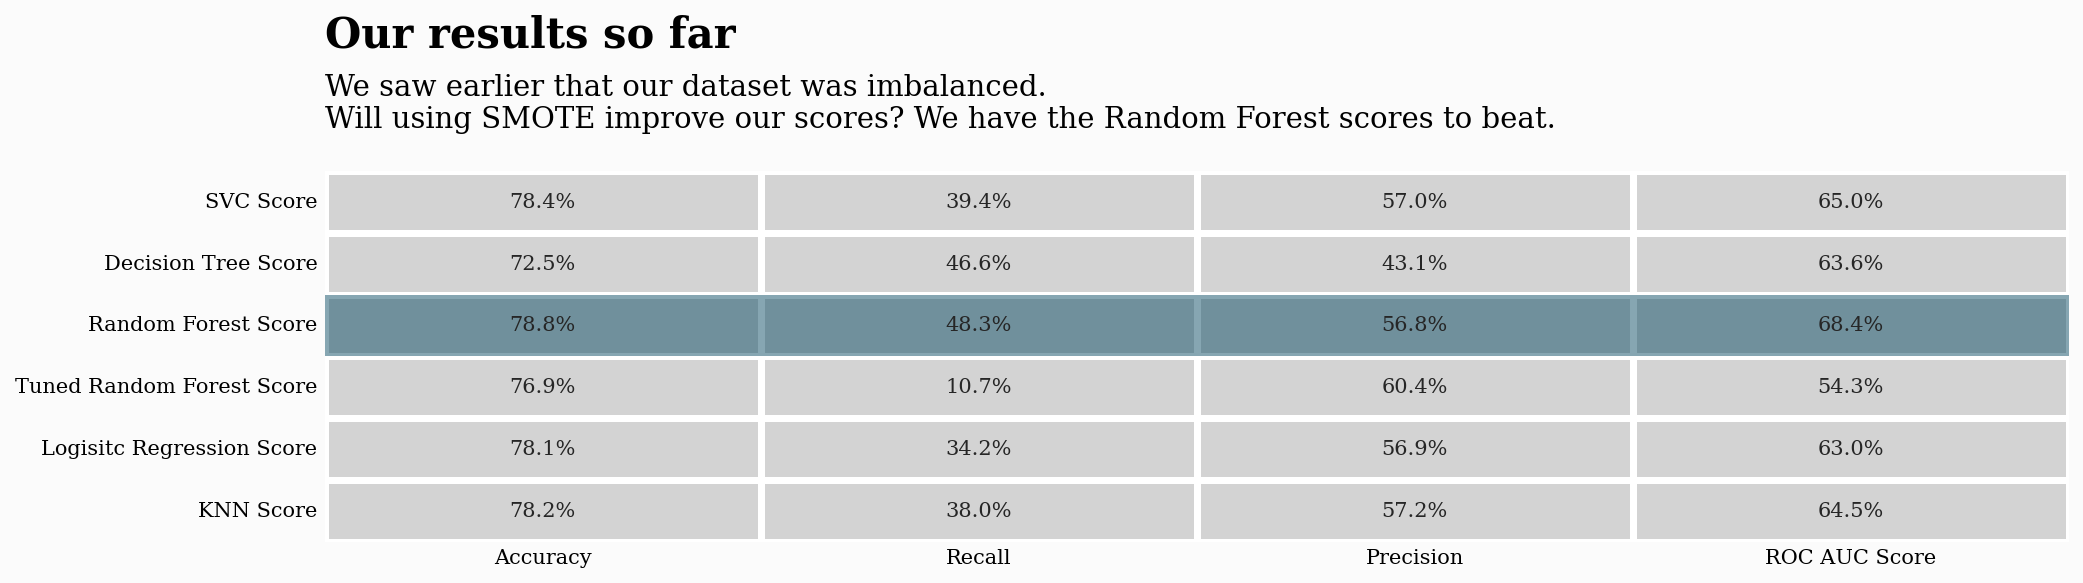

In [34]:
fig = plt.figure(figsize=(15,18), dpi=150)
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

colors = ["lightgray","lightgray"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

# Overall
df_models = round(pd.concat([svc_df,dtree_df,rfc_df,trfc_df,log_df,knn_df], axis=1),3)
sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax0)

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax0.text(0,-2,'Our results so far',fontfamily='serif',fontsize=20,fontweight='bold')
ax0.text(0,-0.7,'We saw earlier that our dataset was imbalanced.\nWill using SMOTE improve our scores? We have the Random Forest scores to beat.',fontfamily='serif',fontsize=14)

from matplotlib.patches import Rectangle

rect = ax0.add_patch(Rectangle((0, 2), 5, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))



plt.show()